# Orion Conceptual Design

## Introduction
This notebook contains the basic design concept exploration for the orion rocket.
- Rocketpy used for low-fidelity models to sketch out mass constraints for 25km agogee shot
- Use of only existing rocketpy features (solid rocket motor engine *mocking* performance of final liquid)

In [2]:
from typing import Union, Tuple

# Import rocketpy from the rocketpy directory
from importlib.machinery import SourceFileLoader
rocketpy = SourceFileLoader("rocketpy", "../rocketpy/__init__.py").load_module()


# The KSP fork should be used
print(rocketpy.__version__)

0.12.0 fork for KSP


## Environment
The launch environment is not particularly useful here, we use the standard atmosphere, launching from campus.

launch site location:
http://maps.google.com/maps?q=-5.68027,55.433159

Launch Site Details

Launch Rail Length: 4  m
Launch Date: 2022-11-20 12:00:00 UTC
Launch Site Latitude: 55.43316°
Launch Site Longitude: -5.68027°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 330421.07 W    6146261.83 N
Launch Site UTM zone: 30U
Launch Site Surface Elevation: 40.0 m


Atmospheric Model Details

Atmospheric Model Type: StandardAtmosphere
StandardAtmosphere Maximum Height: 80.000 km


Surface Atmospheric Conditions

Surface Wind Speed: 0.00 m/s
Surface Wind Direction: 0.00°
Surface Wind Heading: 0.00°
Surface Pressure: 1008.45 hPa
Surface Temperature: 287.89 K
Surface Air Density: 1.220 kg/m³
Surface Speed of Sound: 340.13 m/s


Atmospheric Model Plots


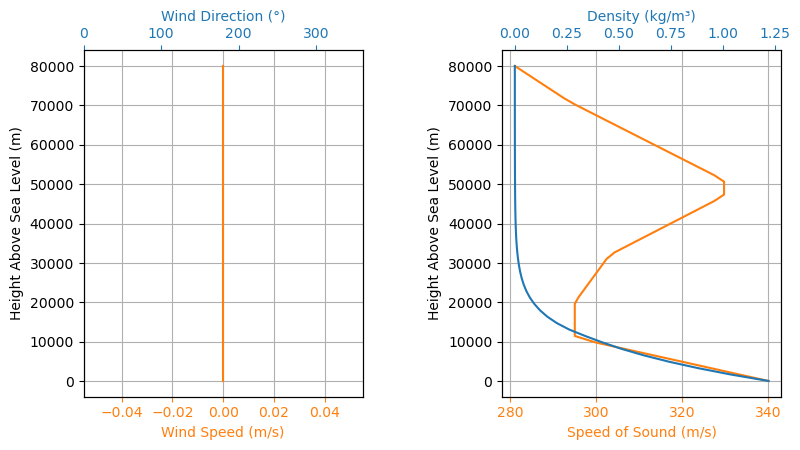

In [3]:
from datetime import date

today = date.today()


LAUNCH_LONGITUDE: float = -5.680270
LAUNCH_LATITUDE: float  = 55.433159

# Coordinates on google maps
print(f"launch site location:\nhttp://maps.google.com/maps?q={LAUNCH_LONGITUDE},{LAUNCH_LATITUDE}\n")


LAUNCH_RAIL_LENGTH: float = 4 

Env = rocketpy.Environment(
    railLength=LAUNCH_RAIL_LENGTH,
    latitude=LAUNCH_LATITUDE,
    longitude=LAUNCH_LONGITUDE,
    elevation=40,
    date=(today.year, today.month, today.day, 12) # Launch today at 12:00
) 

Env.setAtmosphericModel(
    type="StandardAtmosphere"
)

Env.info()

## Constants Table
Used for all the major constants for orion's design

### Nose Cone & Recovery

In [4]:
# GUESS FIGURE - PLEASE CORRECT

# Nose cone type: "Von Karman", "conical", "ogive", "lvhaack"
NOSE_CONE_TYPE: str = "lvhaack"
NOSE_CONE_LENGTH_M: float = 0.435
NOSE_CONE_MASS_KG: float = 0.4

RECOVERY_SECTION_HEIGHT_M: float = 0.1
RECOVERY_SECTION_MASS_KG: float = 0.5

### Avionics Bay

In [5]:
AVIONICS_MASS_KG: float = 1.5
AVIONICS_BAY_HEIGHT_M: float = 0.4

### Tank Section
- 3 main tanks (nitrogen pressuriser, fuel & oxidiser)
- pressure regulator used to keep constant pressure into the fuel/oxidiser tanks

In [6]:
OXIDISER_TANK_HEIGHT_M: float = 1.1
OXIDISER_TANK_MASS_KG: float = 5
OXIDISER_MASS_KG: float = 30

FUEL_TANK_HEIGHT_M: float = 0.5
FUEL_TANK_MASS_KG: float = 2.5
FUEL_MASS_KG: float = 10

NITROGEN_TANK_HEIGHT_M: float = 0.4
NITROGEN_TANK_MASS_KG: float = 2.5
NITROGEN_MASS_KG: float = 8

### Engine Section
This includes the engine plumbing.

In [7]:
ENGINE_AND_PLUMBING_HEIGHT_M: float = 0.5
ENGINE_AND_PLUMBING_MASS_KG: float = 5

### Aerodynamic Stability (Fins)

In [8]:
NO_FINS: int = 4
FIN_MASS_KG: float = 0.648
FIN_ROOT_CHORD_M: float = 0.29
FIN_TIP_CHORD_M: float = 0.080
FIN_SPAN_M: float = 0.100
FINS_CM_M: float = 0.28
FIN_POSITION: float = 0.1

### Structures 

In [9]:
ORION_DIAMETER_M: float = 0.2
ORION_SHELL_MASS_KG: float = 23.25

## Rocket Construction
Using the provided constants to create a basic rocketpy rocket:
- Includes any maths on constants to align with rocketpy api (e.g finding component centroids)
- Fins, Nosecone added through methods and have no associated object.

In [10]:

from dataclasses import dataclass
from typing import Optional

@dataclass(frozen=True)
class Component:
    name: str
    position: float
    height: float
    dry_mass: float
    wet_mass_change: float = 0
    custom_center_of_mass: Optional[float] = None

    def component_top(self) -> float:
        return self.position + self.height

    def center_of_mass(self) -> float:
        return self.position + (self.custom_center_of_mass if self.custom_center_of_mass is not None else self.height / 2) 
        

engine = Component(
    name="Engine and plumming", 
    position=0, 
    height=ENGINE_AND_PLUMBING_HEIGHT_M, 
    dry_mass=ENGINE_AND_PLUMBING_MASS_KG
)

fuel_tank = Component(
    name="Fuel Tank", 
    position=engine.component_top(), 
    height=FUEL_TANK_HEIGHT_M, 
    dry_mass=FUEL_TANK_MASS_KG, 
    wet_mass_change=FUEL_MASS_KG
)

oxidiser_tank = Component(
    name="Oxidiser Tank",
    position=fuel_tank.component_top(),
    height=OXIDISER_TANK_HEIGHT_M,
    dry_mass=OXIDISER_TANK_MASS_KG,
    wet_mass_change=OXIDISER_MASS_KG
)

nitrogen_tank = Component(
    name="Pressurising Tank (Nitrogen)",
    position=oxidiser_tank.component_top(),
    height=NITROGEN_TANK_HEIGHT_M,
    dry_mass=NITROGEN_TANK_MASS_KG + NITROGEN_MASS_KG
)

avionics_bay = Component(
    name="Avionics Bay",
    position=nitrogen_tank.component_top(),
    height=AVIONICS_BAY_HEIGHT_M,
    dry_mass=AVIONICS_MASS_KG
)

recovery_section = Component(
    name="Recovery Section",
    position=avionics_bay.component_top(),
    height=RECOVERY_SECTION_HEIGHT_M,
    dry_mass=RECOVERY_SECTION_MASS_KG
)

nose_cone = Component(
    name="Nosecone",
    position=recovery_section.component_top(),
    height=NOSE_CONE_LENGTH_M,
    dry_mass=NOSE_CONE_MASS_KG
)

orion_shell = Component(
    name="Structre/Shell",
    position=0,
    height=nose_cone.position,
    dry_mass=ORION_SHELL_MASS_KG
)

fins = [Component(
    name=f"Fin {i}",
    position=FIN_POSITION,
    height=FIN_ROOT_CHORD_M,
    dry_mass=FIN_MASS_KG,
    custom_center_of_mass=FINS_CM_M,
) for i in range(NO_FINS)]

rocket_body = [
    engine,
    fuel_tank,
    oxidiser_tank,
    nitrogen_tank,
    avionics_bay,
    recovery_section,
    orion_shell,
]

rocket_components = rocket_body + fins + [nose_cone]

# Center of mass calculations
def compute_orion_masses(comps: list[Component]) -> Tuple[float, float, float, float]:
    dry_mass = wet_mass = wet_prod_mass = dry_prod_mass = 0
    for comp in comps:
        dry_mass += comp.dry_mass
        dry_prod_mass += comp.dry_mass * comp.center_of_mass()
        wet_mass += comp.dry_mass + comp.wet_mass_change
        wet_prod_mass += (comp.dry_mass + comp.wet_mass_change) * comp.center_of_mass()
    return dry_mass, wet_mass, dry_prod_mass / dry_mass, wet_prod_mass / wet_mass

orion_dry_mass, orion_wet_mass, orion_dry_cm, orion_wet_cm = compute_orion_masses(rocket_components)

# Inertial I and Z calculations
def compound_inertiaI(rocket_body: list[Component], nose_cone: Component) -> float:
    def cylinder_inertiaI(mass, radius, height) -> float:
        return mass*(3*radius**2 + height**2) / 12

    def cone_inertiaI(mass, radius, height) -> float:
        return 3*mass*(height**2 + 4*radius**2)/80
    
    return (sum([
                cylinder_inertiaI(
                    component.dry_mass, 
                    ORION_DIAMETER_M/2, 
                    component.height
                ) for component in rocket_body]) + 
            cone_inertiaI(
                nose_cone.dry_mass, 
                ORION_DIAMETER_M/2, 
                nose_cone.height
            )
        )

def compound_inertiaZ(rocket_body: list[Component], nose_cone: Component) -> float:
    def cylinder_inertiaZ(mass, radius) -> float:
        return mass*(radius**2)/2

    def cone_inertiaZ(mass, radius) -> float:
        return (3*mass*(radius**2) ) / 10

    return (
        sum([
            cylinder_inertiaZ(
                component.dry_mass, 
                ORION_DIAMETER_M/2
            ) for component in rocket_body]) + 
        cone_inertiaZ(
            nose_cone.dry_mass, 
            ORION_DIAMETER_M/2
        )
    )

inertialI_dry = compound_inertiaI(rocket_body, nose_cone)
inertialZ_dry = compound_inertiaZ(rocket_body, nose_cone)


### Engine Model
As we do not currently have liquid engines in rocketpy, we instead are using a solid rocket motor as a standin.


In [ ]:
motor = rocketpy.Motor(
    thrustSource="engines/Cesaroni_40960O8000-P.eng",
    burnOut=5.1,
    grainNumber=4, # extreme bodge alert!! Figures pulled out of my ass
    grainDensity=1, # extreme bodge alert!! Figures pulled out of my ass
    grainOuterRadius=,
    nozzleRadius=0.8 * (ORION_DIAMETER_M/2),
    throadRadius=0.1 * (ORION_DIAMETER_M/2),
)

## Simulation
Sim of provided rocket with full rocketpy output, and highlighted apogee

In [12]:
# TODO: Sim code goes here


# TODO: Need to highlight apogee
orion = Rocket()
